In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [313]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import random
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve

# Алгоритмы кластеризации 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from catboost.utils import get_roc_curve
from sklearn import metrics
from catboost.utils import get_roc_curve

# Метрика F1:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# для статистики
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

# уберем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install phik

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# фи-коэффициент сопряженности (Phi) для изучения корреляции
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [5]:
# input
DATASET_PATH = '../depression_in_married_couples_in_istanbul.csv'
PREP_DATASET_PATH = '../depression_in_married_couples_in_istanbul_data_prep.csv'

# output
TRAIN_FULL_PATH = '../depression_in_married_couples_in_istanbul_train_full.csv'
TRAIN_PART_PATH = '..depression_in_married_couples_in_istanbul_train_part_b.csv'
TEST_PART_PATH = '../depression_in_married_couples_in_istanbul_test_part.csv'

SCALER_FILE_PATH = '../depression_in_married_couples_in_istanbul_scaler.pkl'

# ЗАГРУЗКА ДАННЫХ

Данные собраны в Стамбуле с помощью онлайн-опросника. Ссылка на датасет: https://www.kaggle.com/datasets/babyoda/depression-in-married-couples

Цель работы: изучение развития депрессии у женатых людей и влияние на этот процесс различных демографических факторов.

Методы: использовался опросник Бека (21 пункт): https://www.b17.ru/blog/128025/?ysclid=lb5398wu8j969283351 По каждому пункту можно получить от 0 до 3 баллов, для диагностики депрессии используется итоговая сумма.

Результаты теста интерпретируются следующим образом:

- 0-9 — отсутствие депрессивных симптомов;
- 10-15 — легкая депрессия (субдепрессия);
- 16-19 — умеренная депрессия;
- 20-29 — выраженная депрессия (средней тяжести);
- 30-63 — тяжелая депрессия.

Описание исходных признаков:
- N - индекс каждого наблюдения.
- Gender: 1 - Female, 2 - Male (Пол: 1 - Ж, 2 - М).
- Education: 1 - Primary, 2 - High School, 3 - Bachelor, 4 - Msc or PhD (Образование: 1 - начальное, 2 - полное среднее, 3 - бакалавр, 4 - магистр или кандидат наук).
- Working Status: 1 - Employed, 2 - Unemployed (Работа: 1 - работает, 2 - безработный).
- Marriage Style: 1 - Arranged Marriage, 2 - Flirt Marriage (Заключение брака: 1 - "по расчету", 2 - "по страсти").
- Status of Having a Child: 1 - Yes, 2 - No (Дети: 1 - да, 2 - нет).
- В1-В21 - балл по соответственному пункту опросника Бека.

Считываем данные. По строкам - наблюдения, по столбцам - признаки.

In [6]:
df = pd.read_csv('C://Users//romal//Desktop//depression_in_married_couples_in_istanbul.csv', sep=',')
df.head()

,n,gender,education,working_status,marriage_style,status_of_having_a_child,B1,B2,B3,B4,...,B12,B13,B14,B15,B16,B17,B18,B19,B20,B21
0,345,2,4,2,2,2,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1,73,2,3,2,2,1,1,1,1,1,...,1,0,1,1,0,1,0,0,0,0
2,107,2,4,2,2,1,0,0,0,1,...,1,0,1,0,0,1,0,0,0,1
3,131,2,4,2,2,1,0,1,0,1,...,0,0,0,0,3,0,0,0,0,0
4,4,2,4,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.tail()

,n,gender,education,working_status,marriage_style,status_of_having_a_child,B1,B2,B3,B4,...,B12,B13,B14,B15,B16,B17,B18,B19,B20,B21
428,401,1,2,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
429,244,1,2,1,1,1,0,0,0,1,...,1,0,1,1,0,1,0,0,1,2
430,333,1,1,1,1,1,0,0,0,0,...,1,2,1,1,1,2,0,0,2,1
431,350,1,3,1,2,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
432,225,1,1,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.sample()

,n,gender,education,working_status,marriage_style,status_of_having_a_child,B1,B2,B3,B4,...,B12,B13,B14,B15,B16,B17,B18,B19,B20,B21
326,414,1,2,1,2,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [9]:
df.shape

(433, 27)

In [10]:
df.columns

Index(['n', 'gender', 'education', 'working_status', 'marriage_style',
       'status_of_having_a_child', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
       'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17',
       'B18', 'B19', 'B20', 'B21'],
      dtype='object')

Обзор количественных данных уместным делать не нахожу. Здесь категориальные материалы (пол, работа, статус брака, наличие детей - бинарные, образование - ранговый). И сами баллы В1-В21 стоит, скорее всего, рассматривать именно как ранги, не как цифры, иначе будут слишком грубые средние и ошибки средней. А потом баллы сложим и тоже результат приведем к рангу, одному из пяти: депрессии нет, депрессия легкая, умеренная, выраженная или тяжелая.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   n                         433 non-null    int64
 1   gender                    433 non-null    int64
 2   education                 433 non-null    int64
 3   working_status            433 non-null    int64
 4   marriage_style            433 non-null    int64
 5   status_of_having_a_child  433 non-null    int64
 6   B1                        433 non-null    int64
 7   B2                        433 non-null    int64
 8   B3                        433 non-null    int64
 9   B4                        433 non-null    int64
 10  B5                        433 non-null    int64
 11  B6                        433 non-null    int64
 12  B7                        433 non-null    int64
 13  B8                        433 non-null    int64
 14  B9                        433 non-null    

Пропусков данных нет, их обработка не требуется.

Давайте в данных поищем дубликаты, вдруг что-нибудь задвоилось. Если такие есть - удалим лишние.

In [12]:
dup = df[df.duplicated()].shape[0]
print(f"Нашлось {dup} дубликатов среди {df.shape[0]} вхождений датасета.")

df.drop_duplicates(keep='first',inplace=True)
print(f"\nПосле удаления дубликатов осталось {df.shape[0]} вхождений датасета.")

Нашлось 3 дубликатов среди 433 вхождений датасета.

После удаления дубликатов осталось 430 вхождений датасета.


Давайте создадим новый признак, по которому будет предполагаться наличие депрессии, — целевой показатель. В отдельном столбце сналала просуммируем баллы от В1 до В21 по каждому вхождению.

In [13]:
df['sum_B'] = df[['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','B13','B14','B15','B16','B17','B18','B19','B20','B21']].sum(axis=1)
df[['sum_B']].head()

,sum_B
0,61
1,12
2,8
3,6
4,1


Теперь в новом признаке вместо сумм баллов присвоим ранги: 1 — отсутствие депрессивных симптомов; 2 — легкая депрессия (субдепрессия); 3 — умеренная депрессия; 4 — выраженная депрессия (средней тяжести); 5 — тяжелая депрессия.

In [14]:
df.loc[df['sum_B'] <= 9, 'sum_B'] = 1
df.loc[(df['sum_B'] >= 10) & (df['sum_B'] <= 15), 'sum_B'] = 2
df.loc[(df['sum_B'] >= 16) & (df['sum_B'] <= 19), 'sum_B'] = 3
df.loc[(df['sum_B'] >= 20) & (df['sum_B'] <= 29), 'sum_B'] = 4
df.loc[df['sum_B'] >= 30, 'sum_B'] = 5
df[['sum_B']].head()

,sum_B
0,5
1,2
2,1
3,1
4,1


Далее удалим из массива столбец с индексом и часть столбцов В с баллами. НО! Из них давайте оставим столбцы В9 (нахожу его особенно важным, поскольку там описываются суицидальные мысли или намерения), В15 (способность работать), В16 (качество сна), В17 (чувство усталости), В18 (аппетит), В19 (потеря веса), В21 (интерес к сексу).

In [15]:
df = df.drop(columns=['n', 'B1','B2','B3','B4','B5','B6','B7','B8','B10','B11','B12','B13','B14','B20'])

In [16]:
df.columns

Index(['gender', 'education', 'working_status', 'marriage_style',
       'status_of_having_a_child', 'B9', 'B15', 'B16', 'B17', 'B18', 'B19',
       'B21', 'sum_B'],
      dtype='object')

###### Сейчас будем признаки бинаризировать с помощью дамми-метода.

По полу:

In [17]:
print(df['gender'].value_counts())
dummy_gender=pd.get_dummies(df['gender']).rename(columns=lambda x:'gender_' +str(x))
print(dummy_gender)

1    279
2    151
Name: gender, dtype: int64
     gender_1  gender_2
0           0         1
1           0         1
2           0         1
3           0         1
4           0         1
..        ...       ...
428         1         0
429         1         0
430         1         0
431         1         0
432         1         0

[430 rows x 2 columns]


По занятости:

In [18]:
print(df['working_status'].value_counts())
dummy_working_status=pd.get_dummies(df['working_status']).rename(columns=lambda x:'working_status_' +str(x))
print(dummy_working_status)

2    295
1    135
Name: working_status, dtype: int64
     working_status_1  working_status_2
0                   0                 1
1                   0                 1
2                   0                 1
3                   0                 1
4                   0                 1
..                ...               ...
428                 1                 0
429                 1                 0
430                 1                 0
431                 1                 0
432                 1                 0

[430 rows x 2 columns]


По форме заключенного брака:

In [19]:
print(df['marriage_style'].value_counts())
dummy_marriage_style=pd.get_dummies(df['marriage_style']).rename(columns=lambda x:'marriage_style_' +str(x))
print(dummy_marriage_style)

2    313
1    117
Name: marriage_style, dtype: int64
     marriage_style_1  marriage_style_2
0                   0                 1
1                   0                 1
2                   0                 1
3                   0                 1
4                   1                 0
..                ...               ...
428                 1                 0
429                 1                 0
430                 1                 0
431                 0                 1
432                 0                 1

[430 rows x 2 columns]


По наличию детей:

In [20]:
print(df['status_of_having_a_child'].value_counts())
dummy_status_of_having_a_child=pd.get_dummies(df['status_of_having_a_child']).rename(columns=lambda x:'status_of_having_a_child_' +str(x))
print(dummy_status_of_having_a_child)

1    295
2    135
Name: status_of_having_a_child, dtype: int64
     status_of_having_a_child_1  status_of_having_a_child_2
0                             0                           1
1                             1                           0
2                             1                           0
3                             1                           0
4                             1                           0
..                          ...                         ...
428                           1                           0
429                           1                           0
430                           1                           0
431                           1                           0
432                           1                           0

[430 rows x 2 columns]


И объединим бинаризированные признаки в массив с остальными.

In [21]:
df_dummy = pd.concat([dummy_gender, dummy_working_status, dummy_marriage_style, dummy_status_of_having_a_child, df], axis=1)
df1 = df_dummy.drop(columns=['gender', 'working_status', 'marriage_style','status_of_having_a_child'])
df1.head()

,gender_1,gender_2,working_status_1,working_status_2,marriage_style_1,marriage_style_2,status_of_having_a_child_1,status_of_having_a_child_2,education,B9,B15,B16,B17,B18,B19,B21,sum_B
0,0,1,0,1,0,1,0,1,4,3,3,3,3,3,3,3,5
1,0,1,0,1,0,1,1,0,3,0,1,0,1,0,0,0,2
2,0,1,0,1,0,1,1,0,4,0,0,0,1,0,0,1,1
3,0,1,0,1,0,1,1,0,4,0,0,3,0,0,0,0,1
4,0,1,0,1,1,0,1,0,4,0,0,0,0,0,0,0,1


###### Рассмотрим корреляции с помощью фи-коэффициента сопряженности (Phi), рекомендуемого для категориальных данных: https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

In [22]:
phik_overview = df1.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['gender_1', 'gender_2', 'working_status_1', 'working_status_2', 'marriage_style_1', 'marriage_style_2', 'status_of_having_a_child_1', 'status_of_having_a_child_2', 'education', 'B9', 'B15', 'B16', 'B17', 'B18', 'B19', 'B21', 'sum_B']


,gender_1,gender_2,working_status_1,working_status_2,marriage_style_1,marriage_style_2,status_of_having_a_child_1,status_of_having_a_child_2,education,B9,B15,B16,B17,B18,B19,B21,sum_B
gender_1,1.00,1.00,0.55,0.55,0.14,0.14,0.00,0.00,0.21,0.15,0.03,0.10,0.15,0.16,0.00,0.14,0.00
gender_2,1.00,1.00,0.55,0.55,0.14,0.14,0.00,0.00,0.21,0.15,0.03,0.10,0.15,0.16,0.00,0.14,0.00
working_status_1,0.55,0.55,1.00,1.00,0.00,0.00,0.00,0.00,0.38,0.00,0.31,0.21,0.13,0.00,0.00,0.00,0.07
working_status_2,0.55,0.55,1.00,1.00,0.00,0.00,0.00,0.00,0.38,0.00,0.31,0.21,0.13,0.00,0.00,0.00,0.07
marriage_style_1,0.14,0.14,0.00,0.00,1.00,1.00,0.34,0.34,0.18,0.00,0.10,0.00,0.00,0.09,0.24,0.00,0.00
marriage_style_2,0.14,0.14,0.00,0.00,1.00,1.00,0.34,0.34,0.18,0.00,0.10,0.00,0.00,0.09,0.24,0.00,0.00
status_of_having_a_child_1,0.00,0.00,0.00,0.00,0.34,0.34,1.00,1.00,0.35,0.00,0.00,0.00,0.20,0.20,0.00,0.17,0.04
status_of_having_a_child_2,0.00,0.00,0.00,0.00,0.34,0.34,1.00,1.00,0.35,0.00,0.00,0.00,0.20,0.20,0.00,0.17,0.04
education,0.21,0.21,0.38,0.38,0.18,0.18,0.35,0.35,1.00,0.17,0.00,0.00,0.00,0.24,0.21,0.15,0.09
B9,0.15,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.17,1.00,0.50,0.34,0.51,0.48,0.47,0.43,0.45


In [23]:
interval_cols = ['gender_1', 'gender_2', 'working_status_1', 'working_status_2', 'marriage_style_1', 'marriage_style_2', 'status_of_having_a_child_1', 'status_of_having_a_child_2', 'education', 'B9', 'B15', 'B16', 'B17', 'B18', 'B19', 'B21', 'sum_B']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

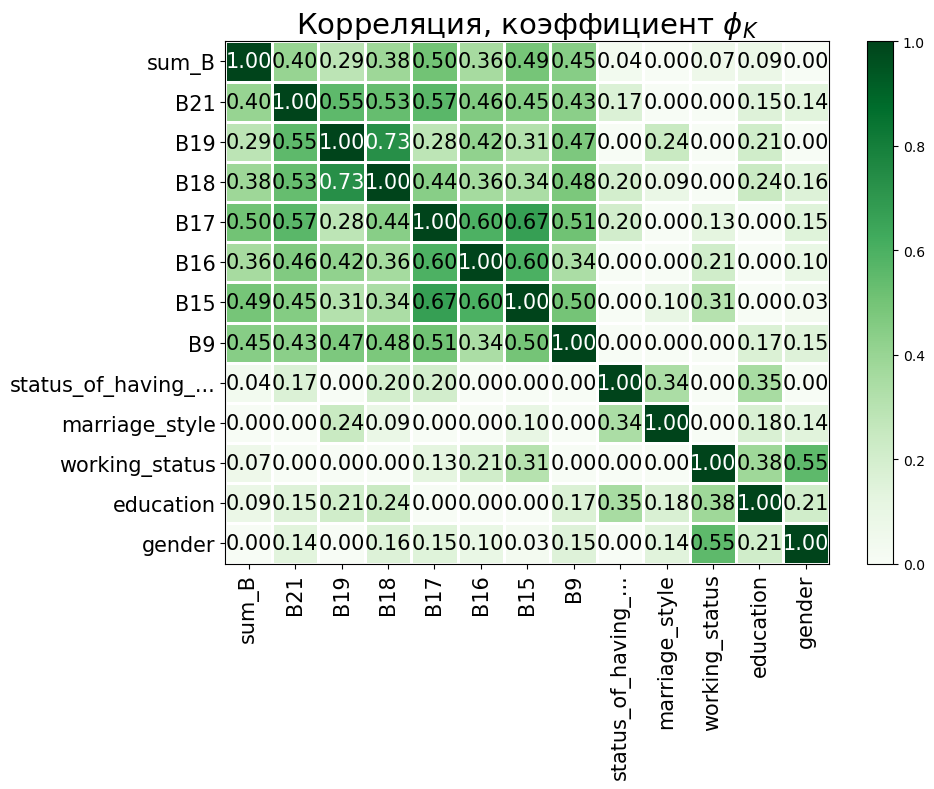

In [24]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция, коэффициент $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

Получается, sumB, депрессия, в опыте не имеет корреляции с социальными факторами?.. Видна лишь слабая связь с образованием и трудоустройством. Это, по-моему, довольно необычно. Депрессии бывают эндогенные (вызванные нарушениями работы нейромедиаторов, встречаются при рекуррентной депрессии, тревожно-депрессивном, биполярном расстройствах, шизофрении; слабее зависят от окружающих факторов, т.е. от среды жизни) и экзогенные (почти полностью зависящие от внешних факторов). Большинство вхождений с депрессией в опыте - эндогенные????? Сообразно ответам на вопросы теста Бека, сильнее всего с наличием дерессии из рассматриваемых оказались связаны В17 (усталость), В15 (способность работать), В9 (суицидальные мысли). Совершенно логично.

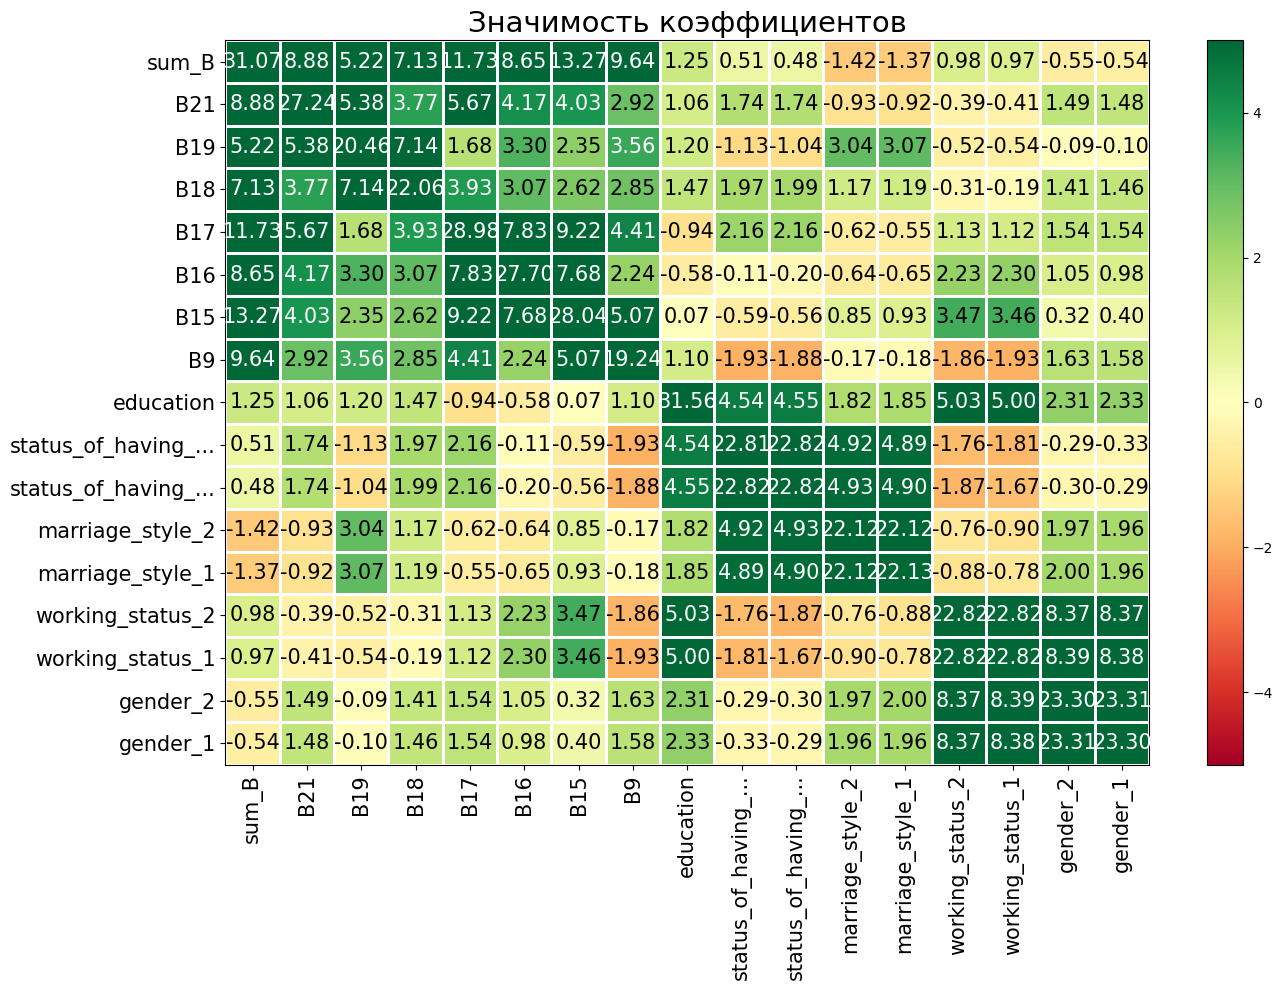

In [25]:
significance_overview = df1.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Значимость коэффициентов", 
                        usetex=False, fontsize_factor=1.5, figsize=(14, 10))
plt.tight_layout()

Глобальный коэффициент корреляции (global correlation, коэффициент gk) — выражающает общую корреляцию одной переменной со всеми другими переменными в наборе данных. Это дает представление о том, насколько хорошо одна переменная может быть смоделирована с использованием других .

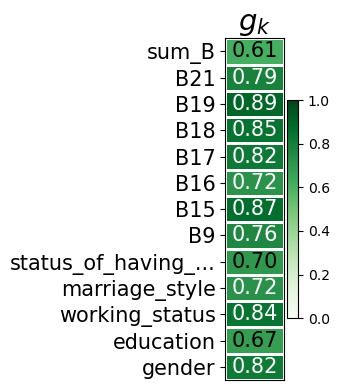

In [26]:
global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

###### Если рассмотреть более традиционный подход, с матрицей корреляции, результаты будут несколько отличаться от фи-коэффициента, но не сильно.

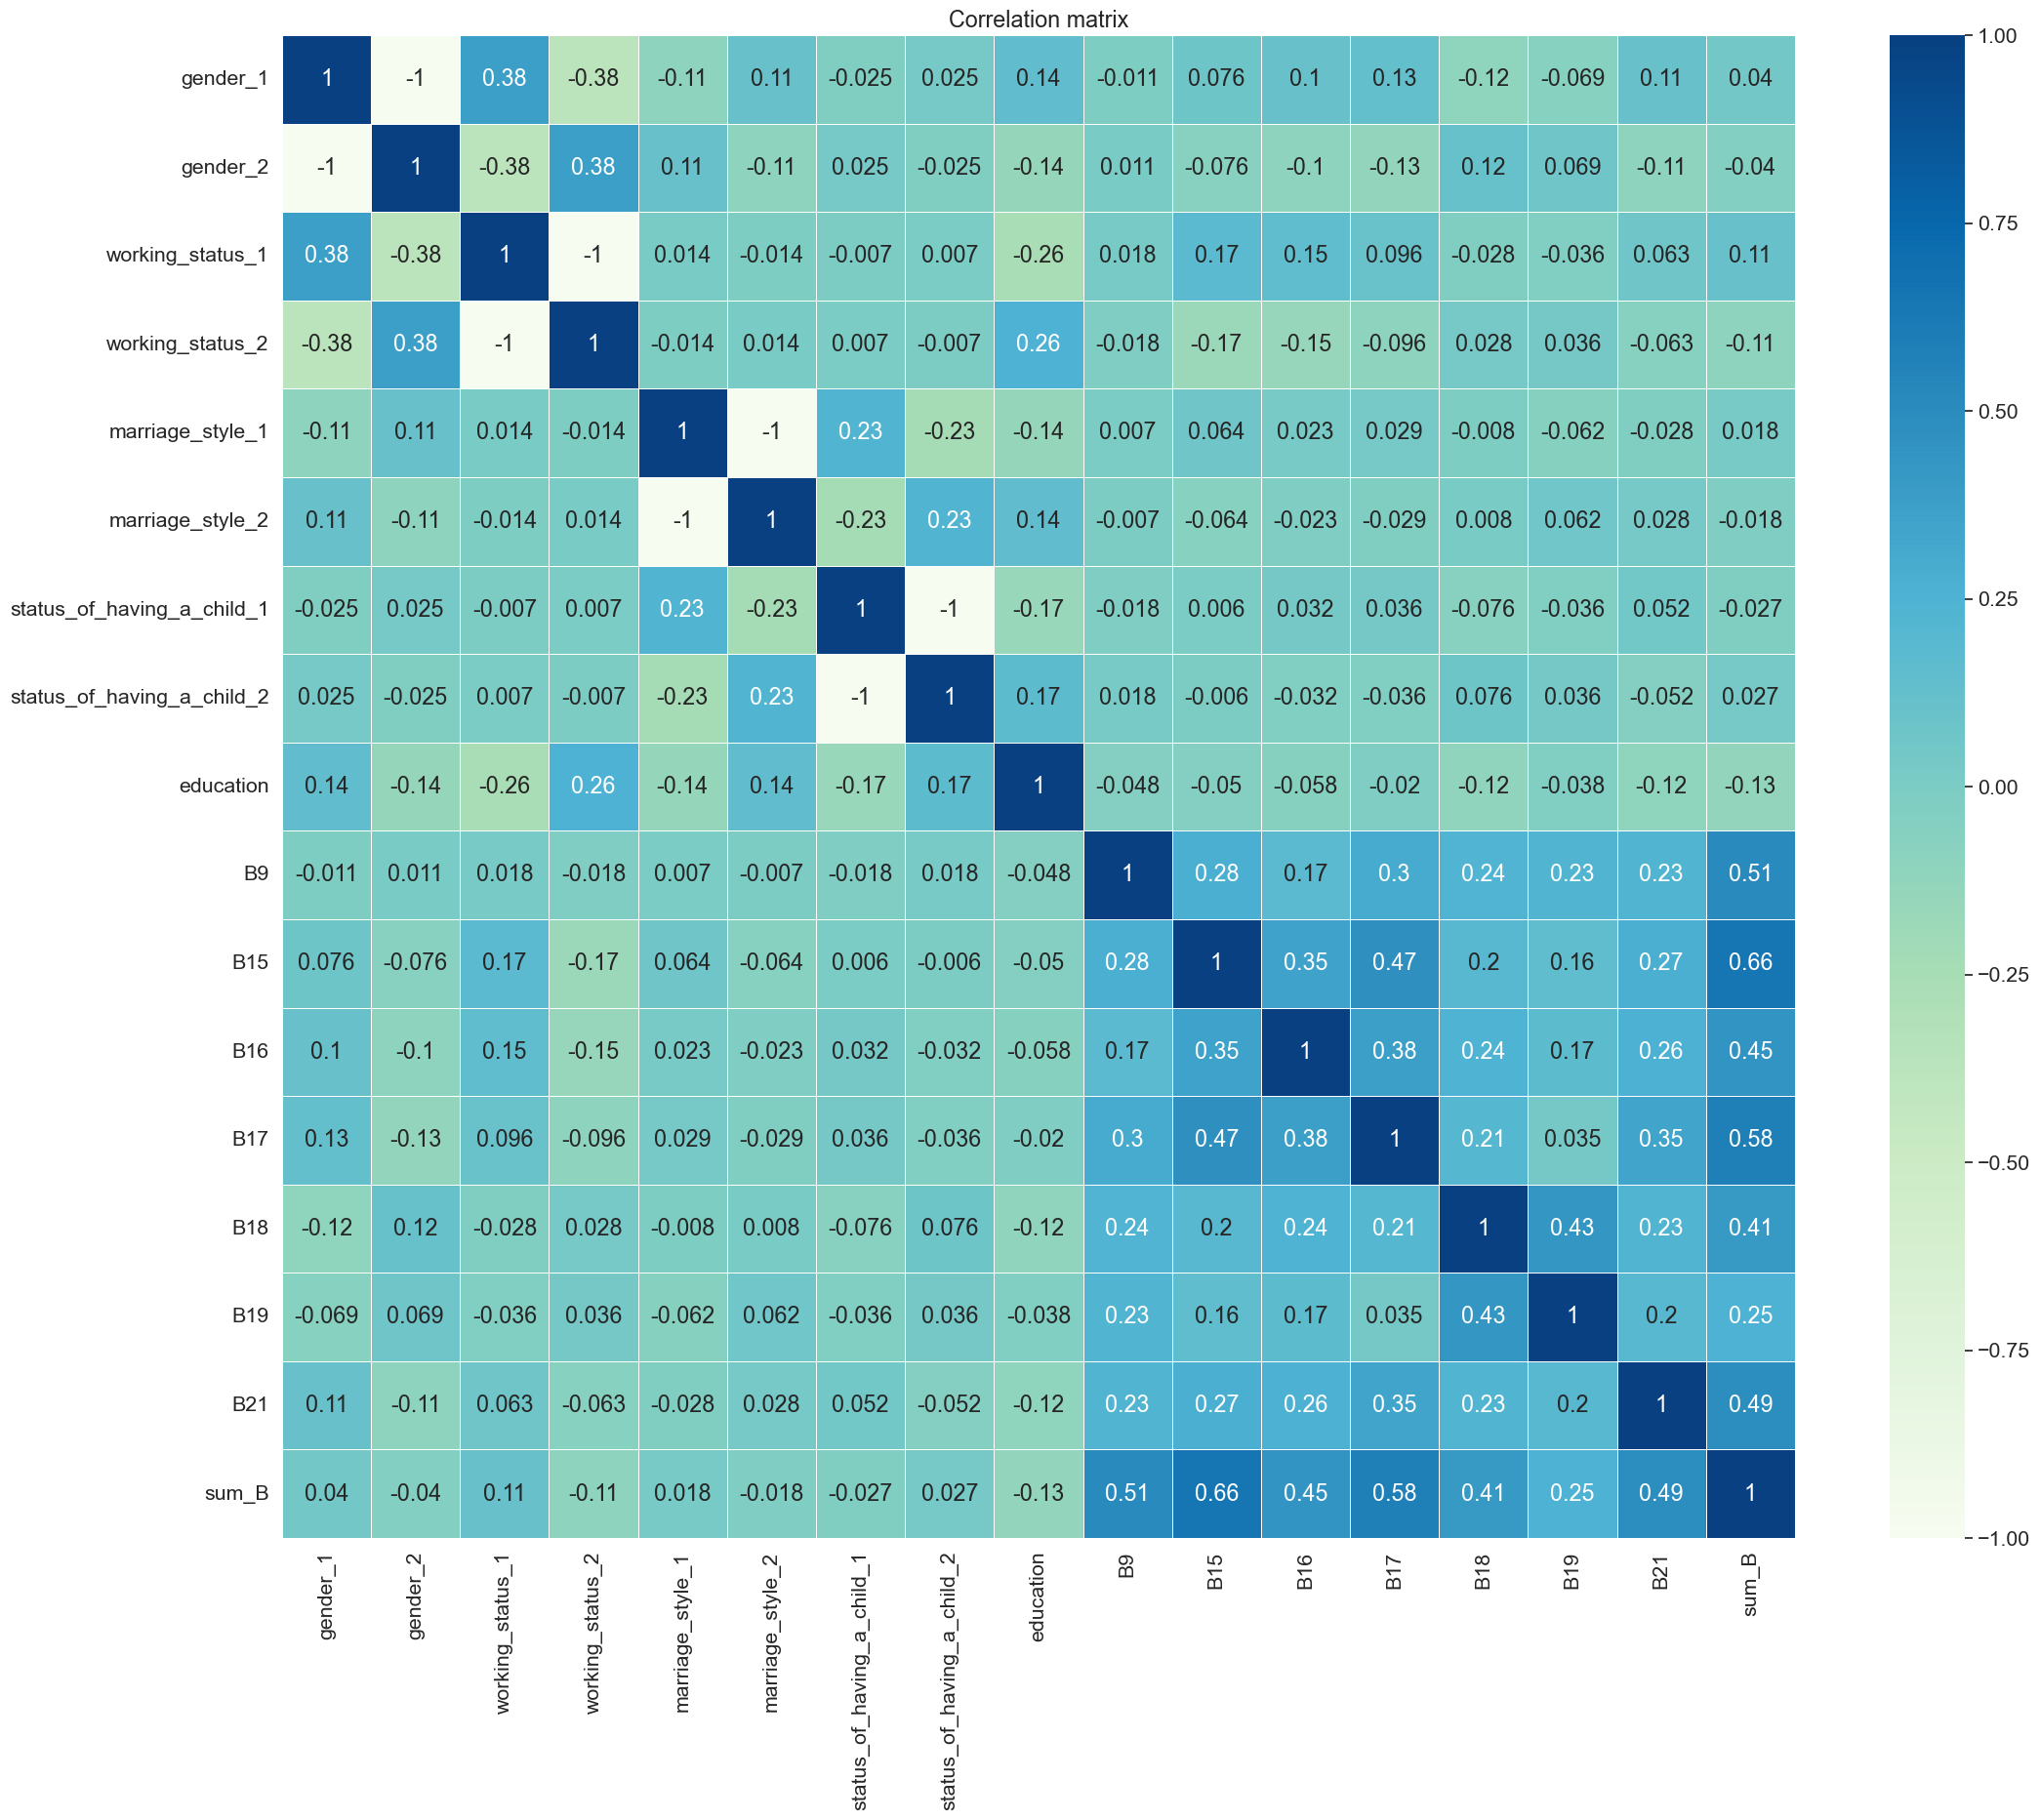

In [27]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df1.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Но и здесь роль демографических факторов видится весьма незначительной. Интересна разве слабая связь с уровнем образования и наличием работы (фи-коэффициент это также показал). Наиболее велика же здесь оказывается роль В15, В17, В9 (тоже согласуется с фи-коэффициентом).

Давайте выделим группу людей с депрессией в целом, от легкой до тяжелой степени (Sum_B от 2 до 5).

In [28]:
df_temp = df.copy()
df_temp_depr = df_temp[df_temp["sum_B"] > 1]
df_temp_depr.head()

,gender,education,working_status,marriage_style,status_of_having_a_child,B9,B15,B16,B17,B18,B19,B21,sum_B
0,2,4,2,2,2,3,3,3,3,3,3,3,5
1,2,3,2,2,1,0,1,0,1,0,0,0,2
7,2,4,2,2,1,1,1,1,1,1,0,0,3
10,2,4,2,2,1,0,1,1,1,2,0,0,2
14,2,3,2,1,1,0,1,1,0,0,1,1,2


###### Как распределяются данные: графики

Рассмотрим распределение случаев депрессии в целом, любой степени, по полу.

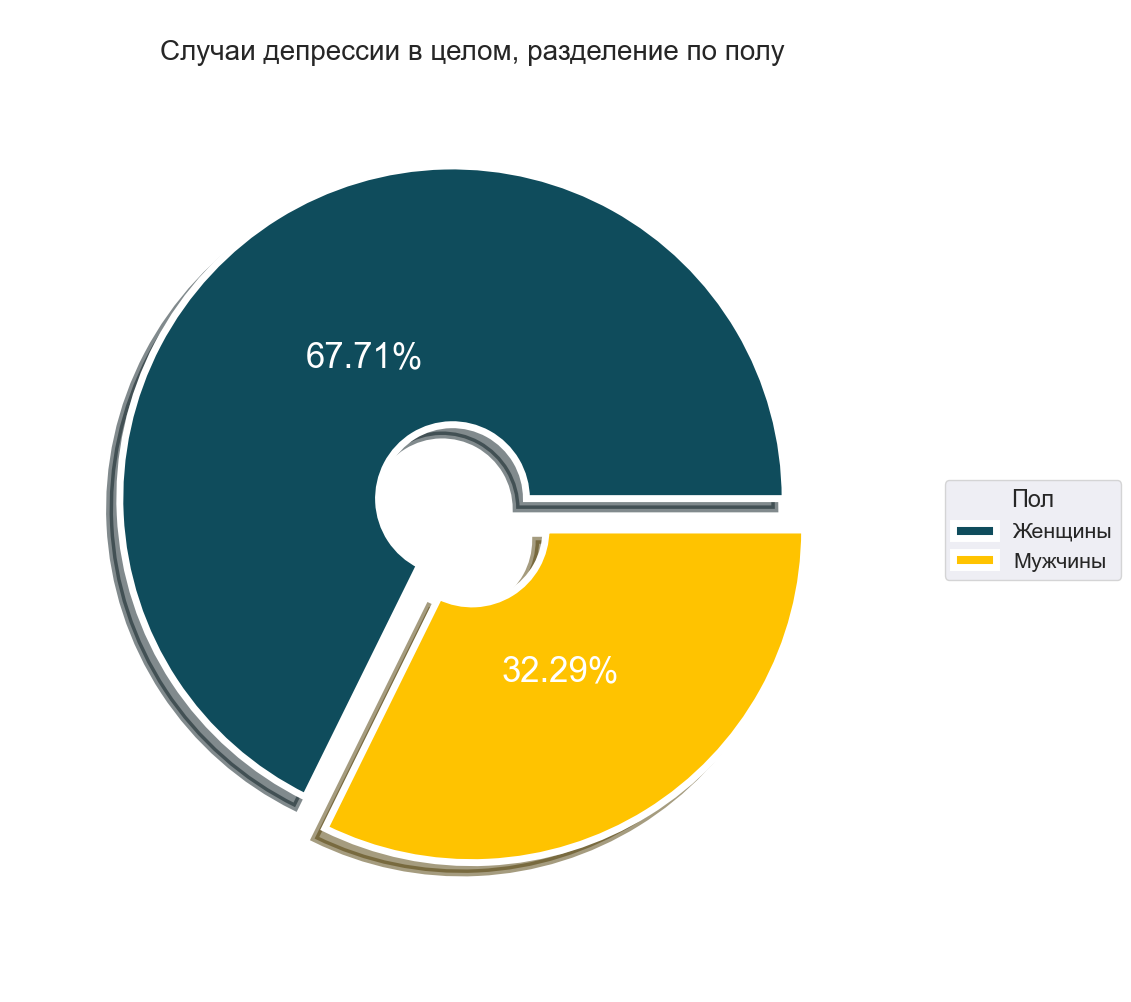

In [29]:
plt.subplots(figsize=(12, 12))

labels = "Женщины","Мужчины"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df_temp_depr[df_temp_depr["gender"] == 1]["gender"]),
                                    len(df_temp_depr[df_temp_depr["gender"]== 2]["gender"])],
                                    explode = (0.1,0),
                                    textprops=dict(size= 25, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.5,
                                    radius=.9, 
                                    colors = ["#0f4c5c","#FFC300"], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5),
                                    startangle = 0)

plt.legend(wedges, labels, title="Пол",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nСлучаи депрессии в целом, разделение по полу",fontsize=20)
plt.show()

Выделим группу с тяжелой депрессией (Sum_B = 5).

In [30]:
df_temp_depr_hard = df_temp[df_temp["sum_B"] == 5]
df_temp_depr_hard

,gender,education,working_status,marriage_style,status_of_having_a_child,B9,B15,B16,B17,B18,B19,B21,sum_B
0,2,4,2,2,2,3,3,3,3,3,3,3,5
118,2,2,2,1,1,3,2,1,2,0,0,0,5
150,2,2,1,2,1,0,1,2,2,3,3,3,5
154,1,4,2,2,1,2,2,0,2,0,0,2,5
226,1,3,2,2,1,1,1,0,3,0,0,3,5
295,1,4,2,2,2,1,1,3,3,1,0,2,5
301,1,3,2,1,1,1,1,2,1,1,1,1,5
391,1,3,1,2,2,3,3,3,3,3,3,3,5
400,1,3,1,2,2,0,1,1,2,3,0,0,5
415,1,2,1,1,1,2,3,1,3,0,0,0,5


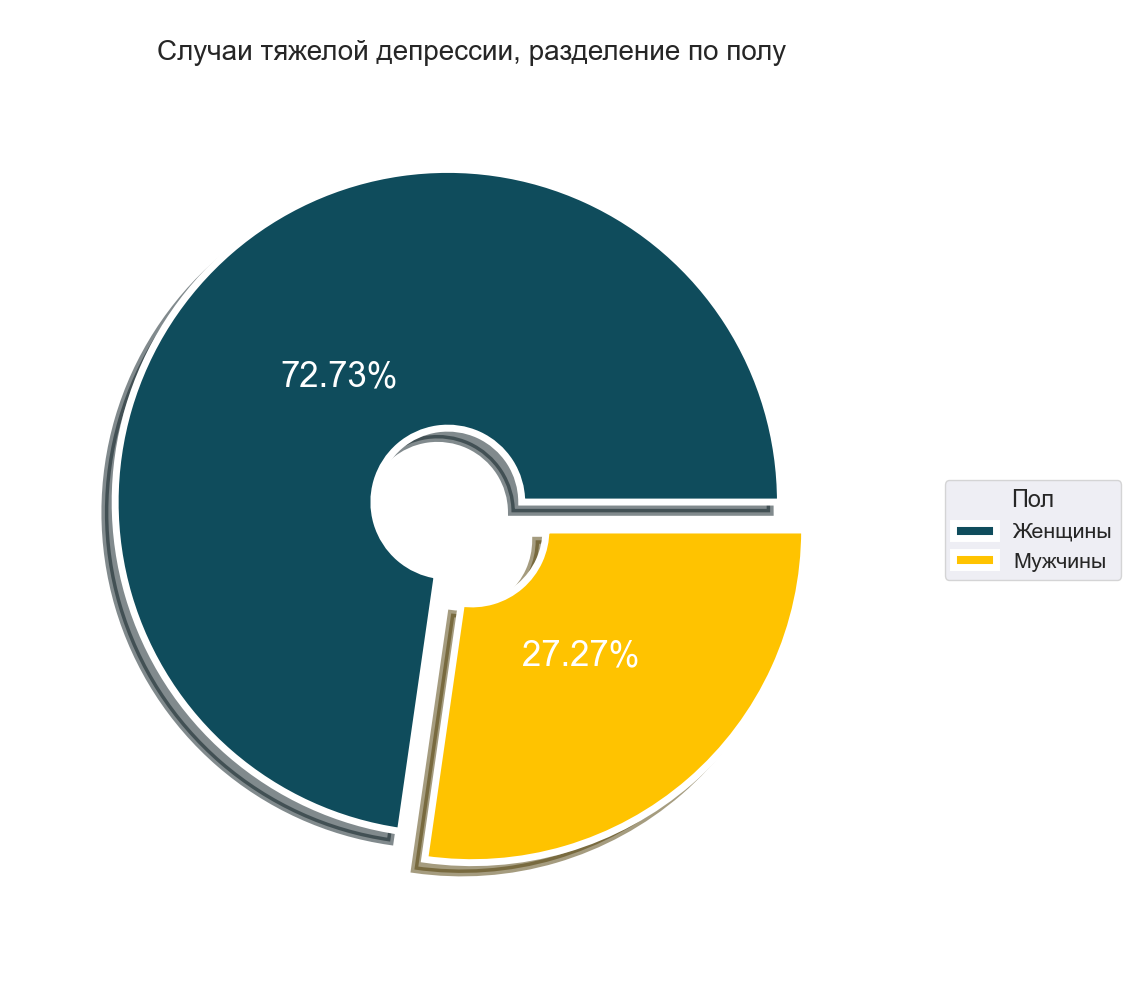

In [31]:
plt.subplots(figsize=(12, 12))

labels = "Женщины","Мужчины"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df_temp_depr_hard[df_temp_depr_hard["gender"] == 1]["gender"]),
                                    len(df_temp_depr_hard[df_temp_depr_hard["gender"]== 2]["gender"])],
                                    explode = (0.1,0),
                                    textprops=dict(size= 25, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.5,
                                    radius=.9, 
                                    colors = ["#0f4c5c","#FFC300"], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5),
                                    startangle = 0)

plt.legend(wedges, labels, title="Пол",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nСлучаи тяжелой депрессии, разделение по полу",fontsize=20)
plt.show()

Посмотрим, насколько часто люди при любой степени тяжести депрессии испытывают серьезные суицидальные мысли (В9 > 1).

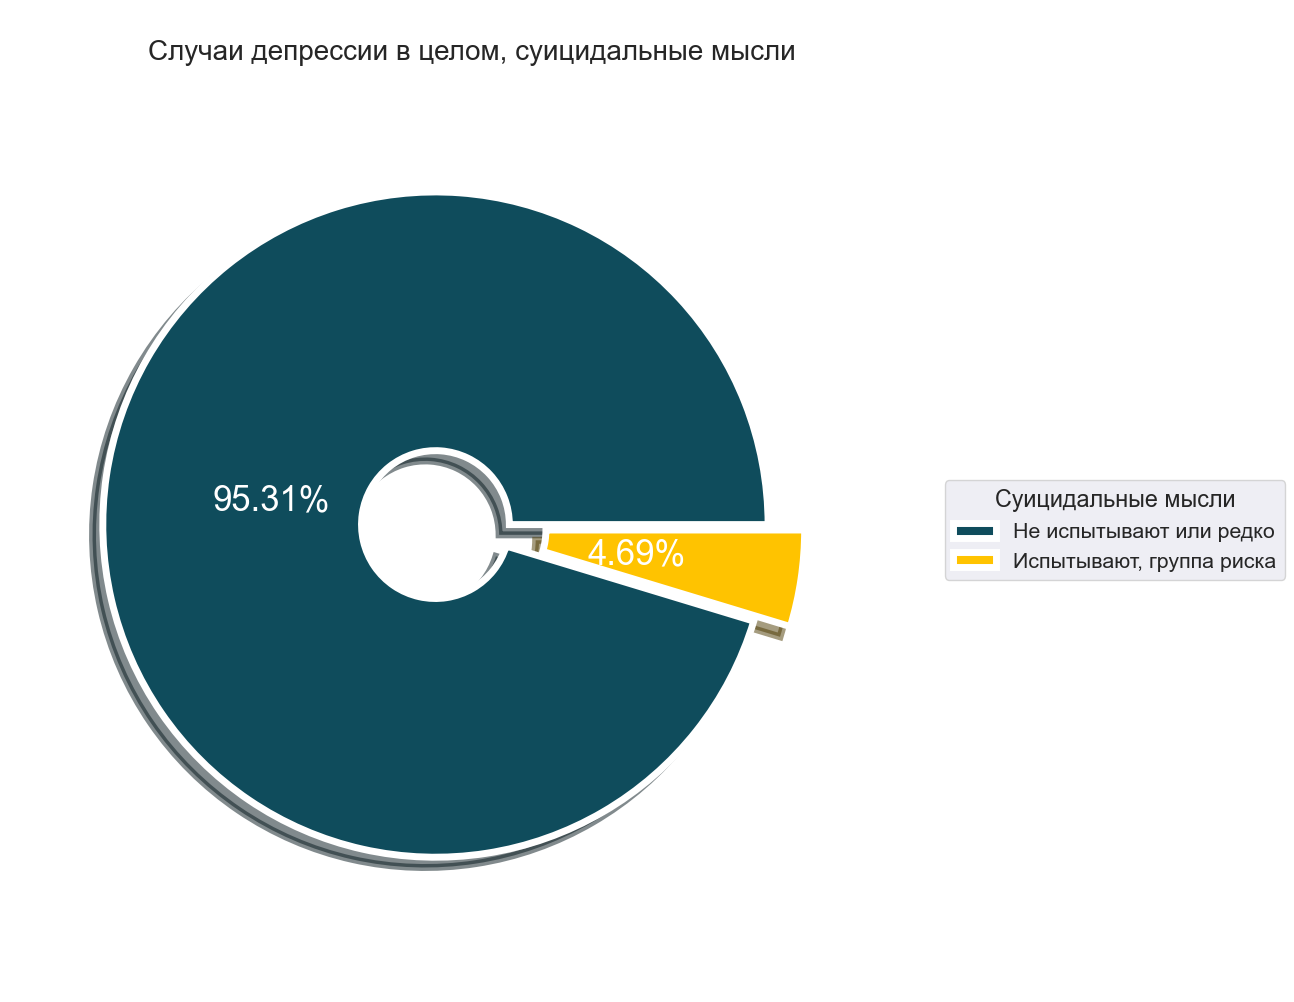

In [32]:
plt.subplots(figsize=(12, 12))

labels = "Не испытывают или редко","Испытывают, группа риска"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df_temp_depr[df_temp_depr["B9"] <= 1]["B9"]),
                                    len(df_temp_depr[df_temp_depr["B9"] > 1]["B9"])],
                                    explode = (0.1,0),
                                    textprops=dict(size= 25, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.5,
                                    radius=.9, 
                                    colors = ["#0f4c5c","#FFC300"], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5),
                                    startangle = 0)

plt.legend(wedges, labels, title="Суицидальные мысли",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nСлучаи депрессии в целом, суицидальные мысли",fontsize=20)
plt.show()

Далее рассмотрим суицидальные мысли в группе с тяжелой депрессией.

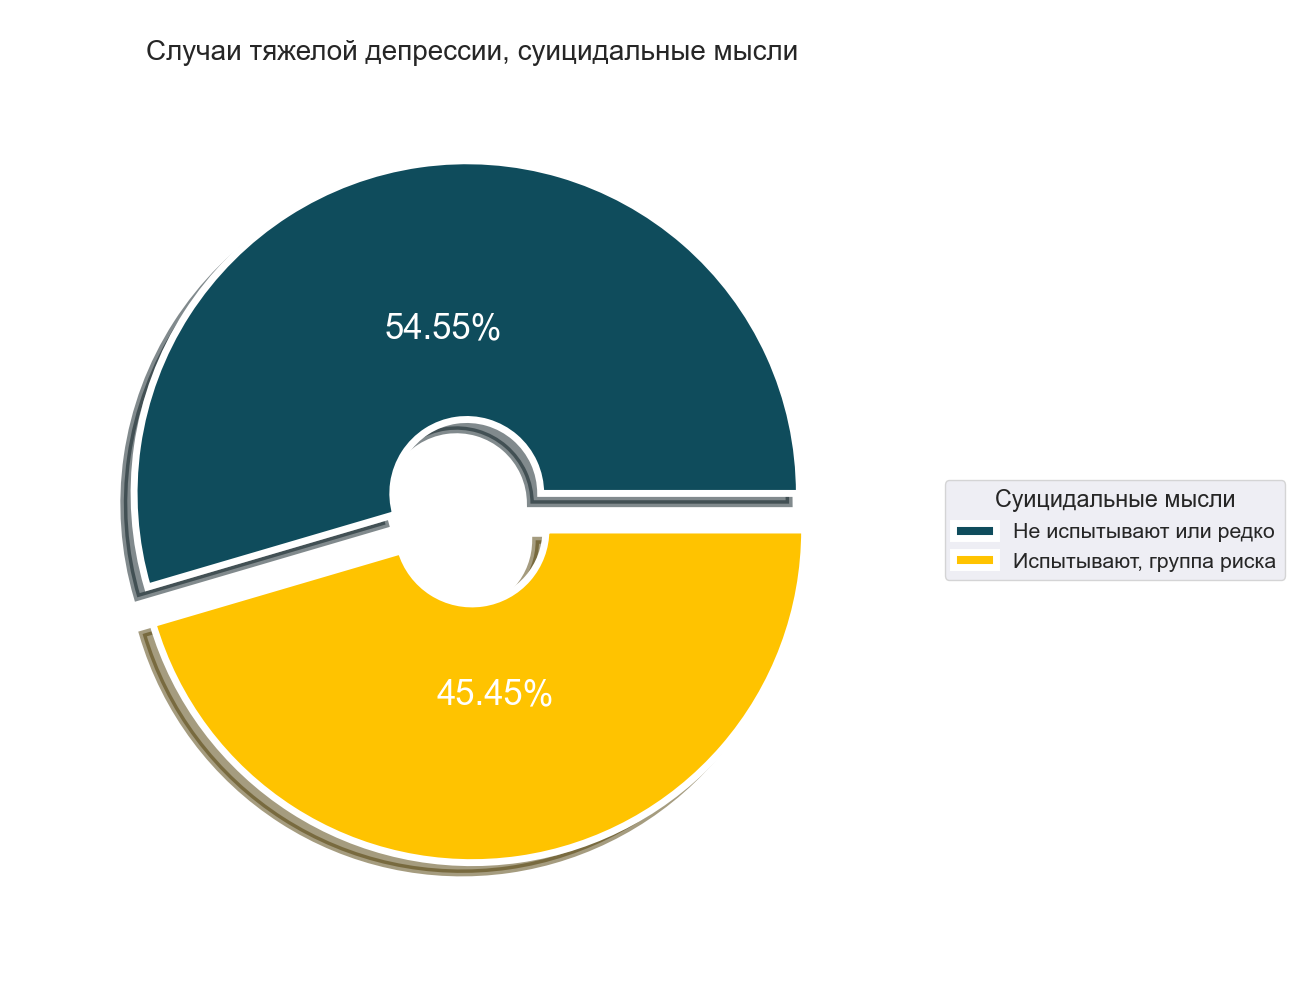

In [33]:
plt.subplots(figsize=(12, 12))

labels = "Не испытывают или редко","Испытывают, группа риска"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df_temp_depr_hard[df_temp_depr_hard["B9"] <= 1]["B9"]),
                                    len(df_temp_depr_hard[df_temp_depr_hard["B9"] > 1]["B9"])],
                                    explode = (0.1,0),
                                    textprops=dict(size= 25, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.5,
                                    radius=.9, 
                                    colors = ["#0f4c5c","#FFC300"], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5),
                                    startangle = 0)

plt.legend(wedges, labels, title="Суицидальные мысли",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nСлучаи тяжелой депрессии, суицидальные мысли",fontsize=20)
plt.show()

Давайте посмотрим, у людей с детьми депрессия в целом чаще встречается у отцов или у матерей?

In [34]:
df_temp_depr_parent = df_temp[(df_temp["sum_B"] > 1) & (df_temp["status_of_having_a_child"] == 1)]
df_temp_depr_parent.head()

,gender,education,working_status,marriage_style,status_of_having_a_child,B9,B15,B16,B17,B18,B19,B21,sum_B
1,2,3,2,2,1,0,1,0,1,0,0,0,2
7,2,4,2,2,1,1,1,1,1,1,0,0,3
10,2,4,2,2,1,0,1,1,1,2,0,0,2
14,2,3,2,1,1,0,1,1,0,0,1,1,2
15,2,2,2,1,1,0,1,1,1,0,0,1,4


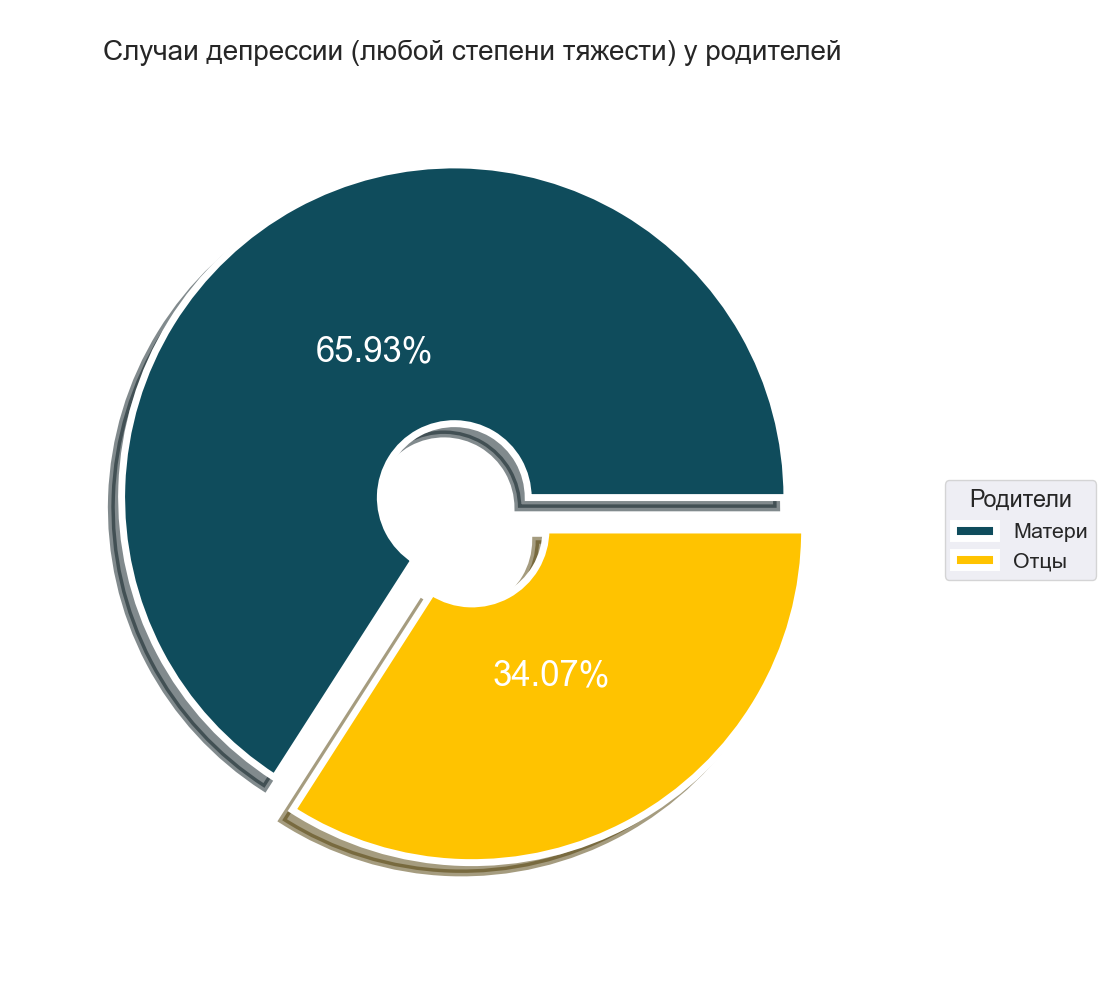

In [35]:
plt.subplots(figsize=(12, 12))

labels = "Матери","Отцы"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df_temp_depr_parent[df_temp_depr_parent["gender"] == 1]["gender"]),
                                    len(df_temp_depr_parent[df_temp_depr_parent["gender"] == 2]["gender"])],
                                    explode = (0.1,0),
                                    textprops=dict(size= 25, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.5,
                                    radius=.9, 
                                    colors = ["#0f4c5c","#FFC300"], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5),
                                    startangle = 0)

plt.legend(wedges, labels, title="Родители",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nСлучаи депрессии (любой степени тяжести) у родителей",fontsize=20)
plt.show()

Рассмотрим уровень образования по общему массиву опыта в целом.

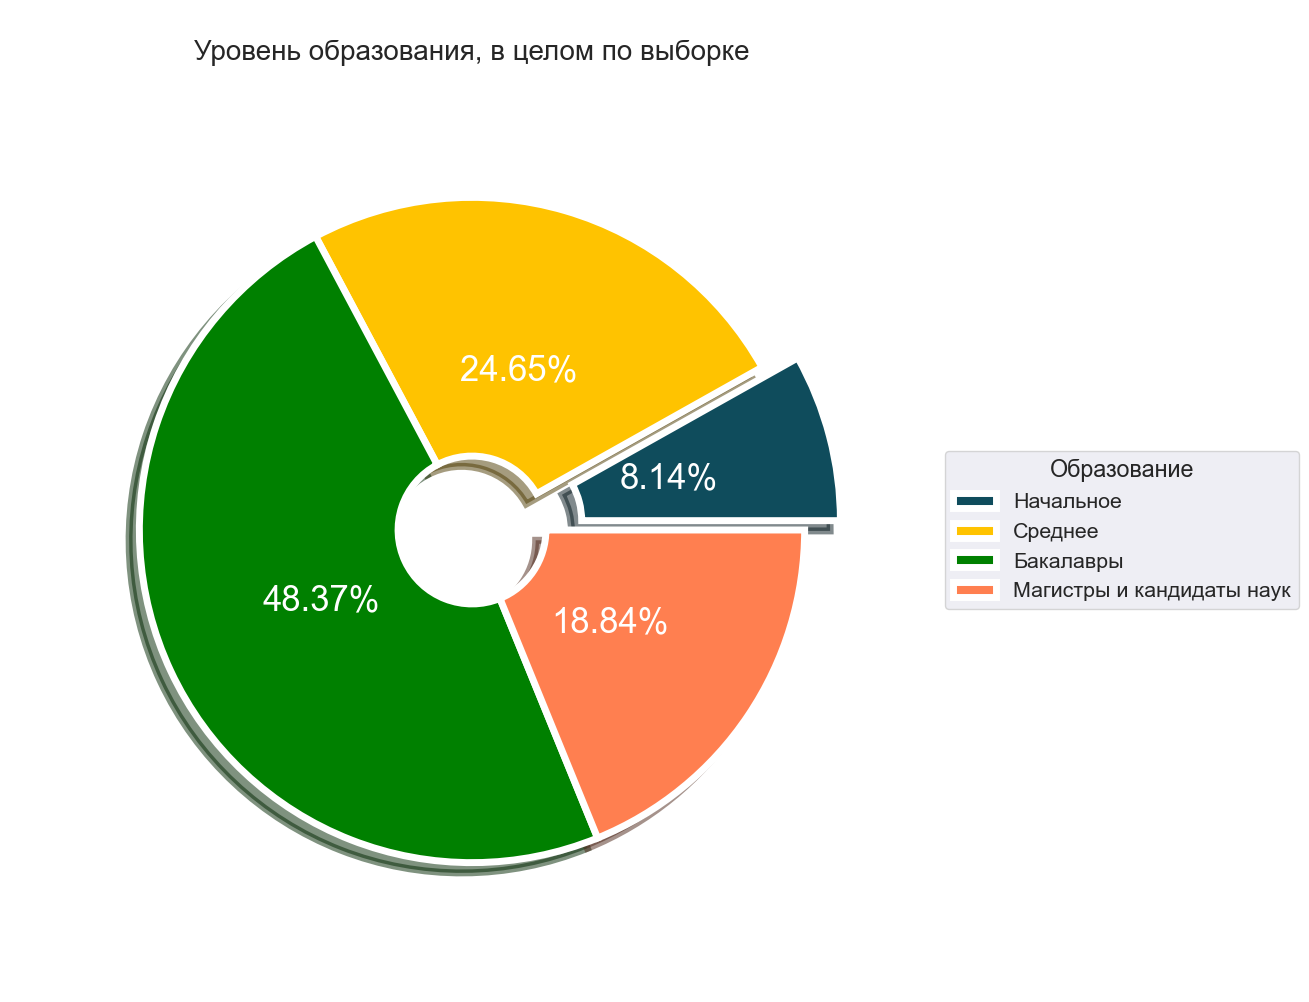

In [36]:
plt.subplots(figsize=(12, 12))

labels = "Начальное","Среднее","Бакалавры","Магистры и кандидаты наук"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df[df["education"] == 1]["education"]),
                                    len(df[df["education"] == 2]["education"]),
                                    len(df[df["education"] == 3]["education"]),
                                    len(df[df["education"] == 4]["education"])],
                                    explode = (0.1,0,0,0),
                                    textprops=dict(size= 25, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.5,
                                    radius=.9, 
                                    colors = ["#0f4c5c","#FFC300", "#008000", "#FF7F50"], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5),
                                    startangle = 0)

plt.legend(wedges, labels, title="Образование",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nУровень образования, в целом по выборке",fontsize=20)
plt.show()

И уровень образования в группе с депрессией.

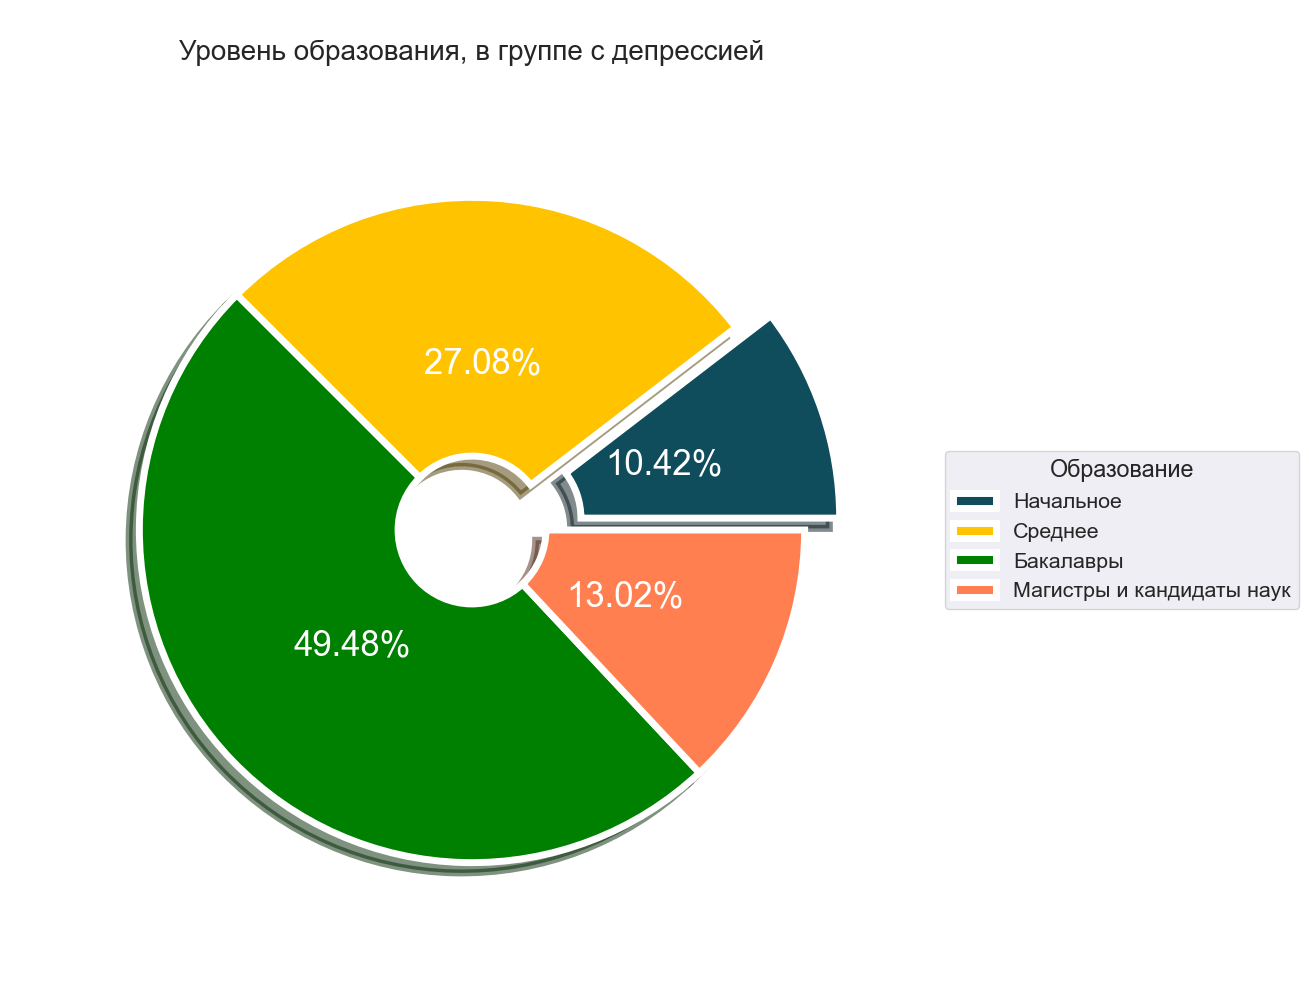

In [37]:
plt.subplots(figsize=(12, 12))

labels = "Начальное","Среднее","Бакалавры","Магистры и кандидаты наук"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df_temp_depr[df_temp_depr["education"] == 1]["education"]),
                                    len(df_temp_depr[df_temp_depr["education"] == 2]["education"]),
                                    len(df_temp_depr[df_temp_depr["education"] == 3]["education"]),
                                    len(df_temp_depr[df_temp_depr["education"] == 4]["education"])],
                                    explode = (0.1,0,0,0),
                                    textprops=dict(size= 25, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.5,
                                    radius=.9, 
                                    colors = ["#0f4c5c","#FFC300", "#008000", "#FF7F50"], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5),
                                    startangle = 0)

plt.legend(wedges, labels, title="Образование",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nУровень образования, в группе с депрессией",fontsize=20)
plt.show()

# ПРИЗНАКИ И ЦЕЛЕВАЯ ПЕРЕМЕННАЯ

Выделим признаки и целевую переменную:

In [38]:
df1.columns.tolist()

['gender_1',
 'gender_2',
 'working_status_1',
 'working_status_2',
 'marriage_style_1',
 'marriage_style_2',
 'status_of_having_a_child_1',
 'status_of_having_a_child_2',
 'education',
 'B9',
 'B15',
 'B16',
 'B17',
 'B18',
 'B19',
 'B21',
 'sum_B']

In [39]:
feature_names = ['gender_1',
 'gender_2',
 'working_status_1',
 'working_status_2',
 'marriage_style_1',
 'marriage_style_2',
 'status_of_having_a_child_1',
 'status_of_having_a_child_2',
 'education',
 'B9',
 'B15',
 'B16',
 'B17',
 'B18',
 'B19',
 'B21']

target_name = 'sum_B'

In [40]:
df = df1[feature_names + [target_name]]
df.head()

,gender_1,gender_2,working_status_1,working_status_2,marriage_style_1,marriage_style_2,status_of_having_a_child_1,status_of_having_a_child_2,education,B9,B15,B16,B17,B18,B19,B21,sum_B
0,0,1,0,1,0,1,0,1,4,3,3,3,3,3,3,3,5
1,0,1,0,1,0,1,1,0,3,0,1,0,1,0,0,0,2
2,0,1,0,1,0,1,1,0,4,0,0,0,1,0,0,1,1
3,0,1,0,1,0,1,1,0,4,0,0,3,0,0,0,0,1
4,0,1,0,1,1,0,1,0,4,0,0,0,0,0,0,0,1


Рассмотрим особенности целевой переменной, визуализируем:

In [41]:
df[target_name].value_counts()

1    238
2     89
4     58
3     34
5     11
Name: sum_B, dtype: int64

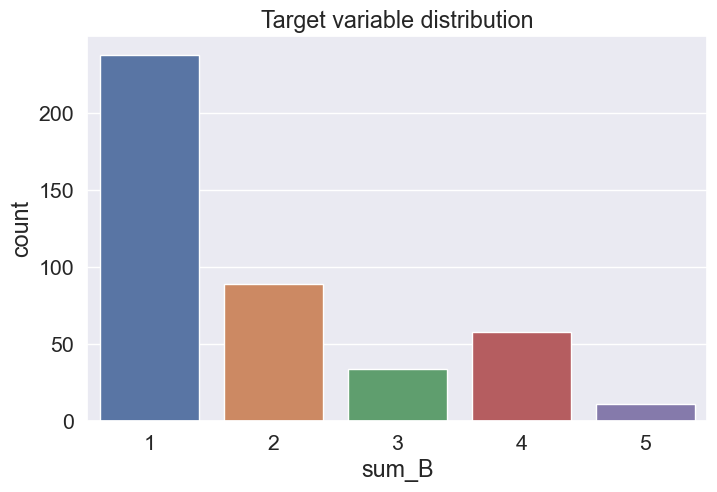

In [42]:
plt.figure(figsize=(8, 5))

sns.countplot(x=target_name, data=df)

plt.title('Target variable distribution')
plt.show()

Упростим работу с целевым показателем: давайте сформируем лишь 2 группы - без депрессии и с депрессией любой тяжести.

In [43]:
df.loc[df['sum_B'] == 1, 'sum_B'] = 0
df.loc[(df['sum_B'] > 1), 'sum_B'] = 1
df[['sum_B']].head(10)

,sum_B
0,1
1,1
2,0
3,0
4,0
5,0
6,0
7,1
8,0
9,0


In [44]:
df[target_name].value_counts()

0    238
1    192
Name: sum_B, dtype: int64

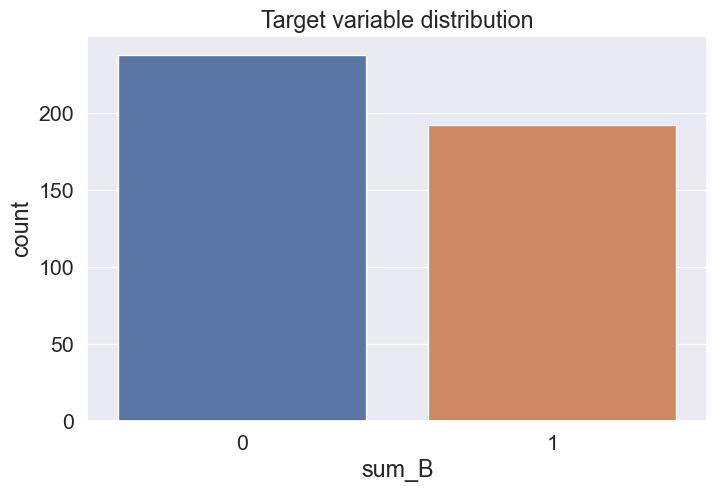

In [45]:
plt.figure(figsize=(8, 5))

sns.countplot(x=target_name, data=df)

plt.title('Target variable distribution')
plt.show()

Классы довольно сбалансированными оказались уже сейчас, но я их постараюсь позднее еще лучше уравновесить.

###### Оценка признака "education" в разрезе целевой переменной

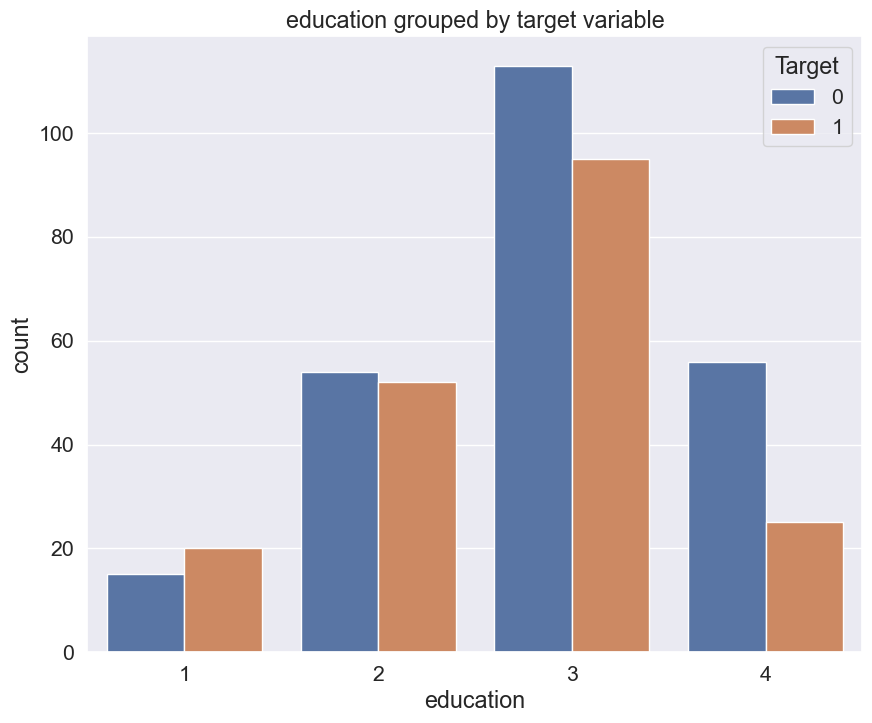

In [46]:
plt.figure(figsize=(10, 8))

sns.countplot(x="education", hue=target_name, data=df)
plt.title('education grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Наблюдение:

Изучив получившийся график, видно, что значения 3 и 4 признака "education" имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет объединить их в одну категорию.

Гипотеза:

Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы. Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы.

- Критерий: Хи-квадрат Пирсона
- Уровень значимости α : 0.05
- Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий 3 и 4 признака "education" в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

Рассмотрим, как группы 3 и 4 разбиваются по целевому показателю (0 или 1):

In [47]:
df_e_3_0 = (df['education'] == 3) & (df['sum_B'] == 0)
df_e_3_0.value_counts()

False    317
True     113
dtype: int64

In [48]:
df_e_3_1 = (df['education'] == 3) & (df['sum_B'] == 1)
df_e_3_1.value_counts()

False    335
True      95
dtype: int64

In [49]:
df_e_4_0 = (df['education'] == 4) & (df['sum_B'] == 0)
df_e_4_0.value_counts()

False    374
True      56
dtype: int64

In [50]:
df_e_4_1 = (df['education'] == 4) & (df['sum_B'] == 1)
df_e_4_1.value_counts()

False    405
True      25
dtype: int64

Итак, высшее образование (бакалавры) и нет депрессии - 113 вхождений, ВО и есть депрессия - 95, степень (магистры и кандидаты наук) и нет депрессии - 56, степень и есть - 25. Сделаем табличку:

In [51]:
data = [{'нет депрессии': 113, 'есть депрессия': 95}, {'нет депрессии': 56, 'есть депрессия': 25}]  
dframe = pd.DataFrame(data, index =['ВО', 'степень']) 
print(dframe)

         нет депрессии  есть депрессия
ВО                 113              95
степень             56              25


Хи-квадрат Пирсона:

In [52]:
chi2, p, dof, expected = chi2_contingency(dframe, correction=False)
p

0.021754746066377513

Число степеней свободы f = (2-1)*(2-1) = 1. Находим по таблице критическое значение критерия хи-квадрат Пирсона, которое при уровне значимости p=0.05 и числе степеней свободы 1 составляет 3.841 (http://elib.mitso.by/bitstream/edoc/772/1/410-414.pdf, таблица 5).

р-значение меньше 0,05, коэффициент корреляции статистически значим. Можно допустить объединение категорий 3 и 4 в одну, 3:

In [53]:
df.loc[df['education'] == 4, 'education'] = 3

# ПРИВЕДЕНИЕ ТИПОВ, РАЗБИЕНИЕ, БАЛАНСИРОВКА

Пишем функцию для classification report:

In [54]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

Пишем функцию для балансировки целевой переменной:

In [55]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [56]:
target_name = 'sum_B'

In [57]:
balance_df_by_target(df, target_name)

,gender_1,gender_2,working_status_1,working_status_2,marriage_style_1,marriage_style_2,status_of_having_a_child_1,status_of_having_a_child_2,education,B9,B15,B16,B17,B18,B19,B21,sum_B
296,1,0,0,1,0,1,0,1,3,1,0,0,0,0,0,2,1
139,0,1,0,1,1,0,1,0,2,0,0,0,0,0,0,0,0
8,0,1,0,1,0,1,1,0,3,0,0,0,0,0,0,0,0
307,1,0,1,0,1,0,1,0,3,0,1,1,1,0,0,0,1
187,1,0,0,1,0,1,1,0,3,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1,0,0,1,0,1,1,0,3,0,0,1,1,0,0,1,0
152,1,0,0,1,0,1,1,0,3,0,1,1,1,0,2,0,0
248,1,0,0,1,0,1,1,0,2,0,0,0,1,0,0,1,0
385,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0


###### Приведение типов к категориальному:

In [58]:
cols_to_exclude = [feature_names]

for col in df.columns:
        df[col] = df[col].astype('category')

In [59]:
df[feature_names].dtypes

gender_1                      category
gender_2                      category
working_status_1              category
working_status_2              category
marriage_style_1              category
marriage_style_2              category
status_of_having_a_child_1    category
status_of_having_a_child_2    category
education                     category
B9                            category
B15                           category
B16                           category
B17                           category
B18                           category
B19                           category
B21                           category
dtype: object

###### Нормализация данных не потребуется на категориальных.

###### Разбиение на train и test:

In [60]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

###### Балансировка целевой переменной:

In [61]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    166
1    135
Name: sum_B, dtype: int64

###### Сохранение обучающего и тестового датасетов

In [62]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [63]:
df.to_csv('C://Users//romal//Desktop//depression_df_corrected.csv', index=False, encoding='utf-8')
train.to_csv('C://Users//romal//Desktop//depression_train.csv', index=False, encoding='utf-8')
test.to_csv('C://Users//romal//Desktop//depression_test.csv', index=False, encoding='utf-8')

# ПОСТРОЕНИЕ МОДЕЛЕЙ

###### Логистическая регрессия:

In [64]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       166
           1       0.89      0.80      0.84       135

    accuracy                           0.86       301
   macro avg       0.87      0.86      0.86       301
weighted avg       0.87      0.86      0.86       301

TEST

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        72
           1       0.94      0.79      0.86        57

    accuracy                           0.88       129
   macro avg       0.89      0.87      0.88       129
weighted avg       0.89      0.88      0.88       129

CONFUSION MATRIX

col_0   0   1
sum_B        
0      69   3
1      12  45


###### K ближайших соседей:

In [65]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       166
           1       0.92      0.74      0.82       135

    accuracy                           0.85       301
   macro avg       0.87      0.84      0.85       301
weighted avg       0.86      0.85      0.85       301

TEST

              precision    recall  f1-score   support

           0       0.78      0.96      0.86        72
           1       0.93      0.67      0.78        57

    accuracy                           0.83       129
   macro avg       0.86      0.81      0.82       129
weighted avg       0.85      0.83      0.82       129

CONFUSION MATRIX

col_0   0   1
sum_B        
0      69   3
1      19  38


##### Бустинговые алгоритмы

###### CatBoost:

In [66]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
cat_features = feature_names
model_catb.fit(X_train, y_train, cat_features=cat_features)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       166
           1       0.88      0.88      0.88       135

    accuracy                           0.89       301
   macro avg       0.89      0.89      0.89       301
weighted avg       0.89      0.89      0.89       301

TEST

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        72
           1       0.84      0.84      0.84        57

    accuracy                           0.86       129
   macro avg       0.86      0.86      0.86       129
weighted avg       0.86      0.86      0.86       129

CONFUSION MATRIX

col_0   0   1
sum_B        
0      63   9
1       9  48


###### LightGBM:

In [67]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       166
           1       0.90      0.84      0.87       135

    accuracy                           0.88       301
   macro avg       0.89      0.88      0.88       301
weighted avg       0.88      0.88      0.88       301

TEST

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        72
           1       0.84      0.74      0.79        57

    accuracy                           0.82       129
   macro avg       0.83      0.81      0.82       129
weighted avg       0.82      0.82      0.82       129

CONFUSION MATRIX

col_0   0   1
sum_B        
0      64   8
1      15  42


###### XGBoost:

In [268]:
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import OneHotEncoder

Преобразуем данные с OneHotEncoder.

In [269]:
#cat_attribs = feature_names
#full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

In [270]:
#encoder = full_pipeline.fit(X_train)
#X_train = encoder.transform(X_train)
#X_test = encoder.transform(X_test)

In [271]:
#model_xgb = xgb.XGBClassifier(random_state=21)
#model_xgb.fit(X_train, y_train)

#y_train_pred = model_xgb.predict(X_train)
#y_test_pred = model_xgb.predict(X_test)

#get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       166
           1       0.98      0.96      0.97       135

    accuracy                           0.98       301
   macro avg       0.98      0.98      0.98       301
weighted avg       0.98      0.98      0.98       301

TEST

              precision    recall  f1-score   support

           0       0.85      0.86      0.86        72
           1       0.82      0.81      0.81        57

    accuracy                           0.84       129
   macro avg       0.84      0.83      0.83       129
weighted avg       0.84      0.84      0.84       129

CONFUSION MATRIX

col_0   0   1
sum_B        
0      62  10
1      11  46


# ВЫБОР ЛУЧШЕЙ МОДЕЛИ И ПОДБОР ГИПЕРПАРАМЕТРОВ

###### Выбор лучшей модели: мне импонирует CatBoost за, пожалуй, оптимальное для подобной медицинской задачи соотношения уровней ошибок 1-го и 2-го рода.

###### Давайте для выбора параметров применим GridSearchCV:

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [ ]:
CBC = CatBoostClassifier()

In [ ]:
 parameters = {'depth'         : [3, 5, 7],
                 'learning_rate' : [0.01, 0.02, 0.04],
                  'iterations'    : [10, 50, 100, 200, 500, 700, 1000]
                 }

In [ ]:
cat_features = feature_names

In [ ]:
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(X_train, y_train, cat_features = cat_features)

In [74]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.8372626931567329

 The best parameters across ALL searched params:
 {'depth': 3, 'iterations': 200, 'learning_rate': 0.02}


###### Можно попробовать подобрать гиперпараметры и другим методом, с RandomizedSearchCV:

In [75]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

In [76]:
params = {'n_estimators':[10, 50, 100, 200, 500, 700, 1000],
          'max_depth':[3, 5, 7]}

In [77]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [78]:
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y, cat_features = cat_features)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001A1AC79EC40>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [10, 50, 100, 200, 500,
                                                         700, 1000]},
                   scoring='f1')

In [79]:
rs.best_params_

{'n_estimators': 700, 'max_depth': 3}

In [80]:
rs.best_score_

0.8073090220741227

Давайте возьмем пока n_estimators = 700, max_depth = 3

# ОБУЧЕНИЕ И ОЦЕНКА ФИНАЛЬНОЙ МОДЕЛИ

In [347]:
%%time

final_model = catb.CatBoostClassifier(depth=3, n_estimators=700, learning_rate=0.02,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train, cat_features = cat_features)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.93      0.88       166
           1       0.90      0.76      0.82       135

    accuracy                           0.85       301
   macro avg       0.86      0.84      0.85       301
weighted avg       0.86      0.85      0.85       301

TEST

              precision    recall  f1-score   support

           0       0.82      0.96      0.88        72
           1       0.93      0.74      0.82        57

    accuracy                           0.86       129
   macro avg       0.88      0.85      0.85       129
weighted avg       0.87      0.86      0.86       129

CONFUSION MATRIX

col_0   0   1
sum_B        
0      69   3
1      15  42
Wall time: 17.9 s


# ИЗУЧЕНИЕ МОДЕЛИ

###### Выбор порога вероятности для определения класса:

In [348]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

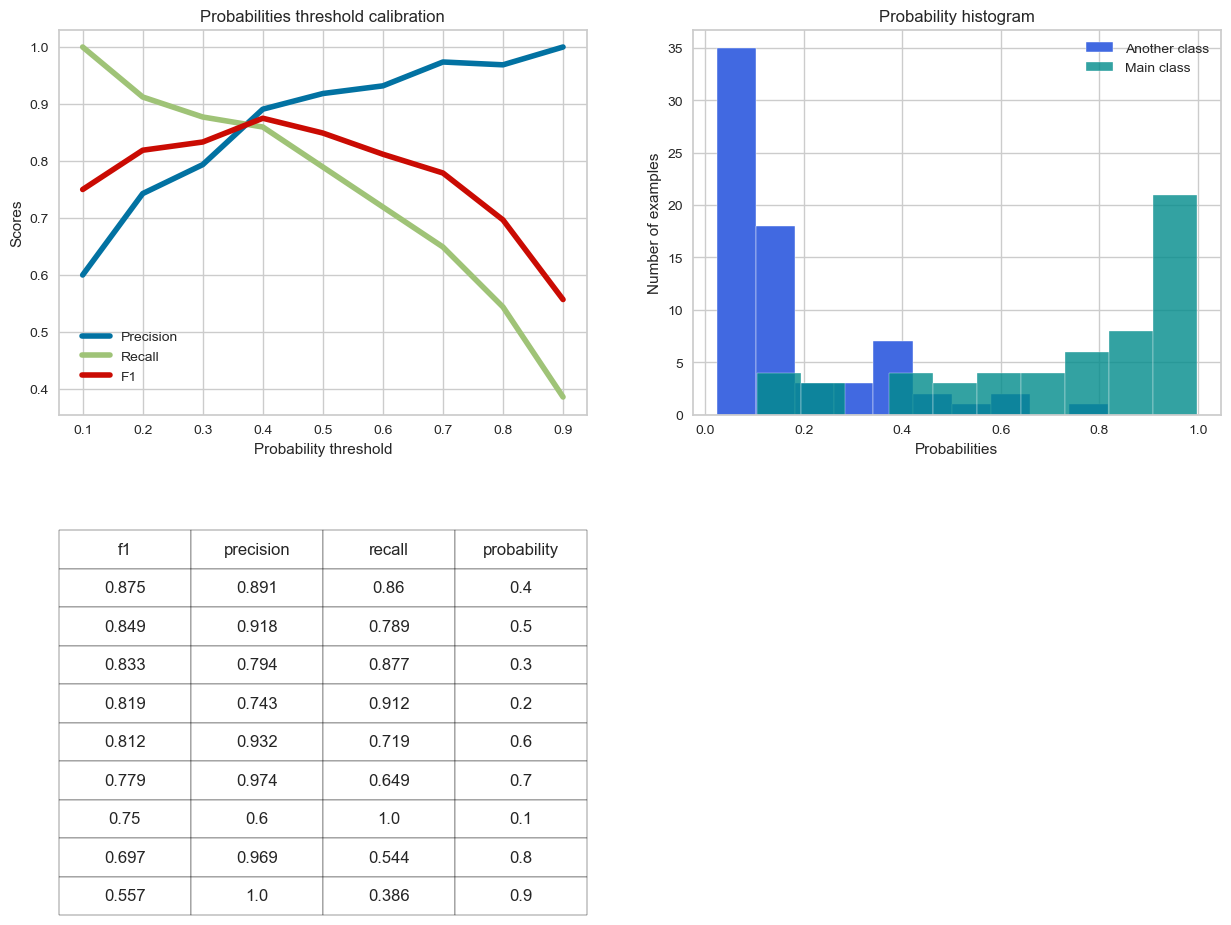

In [349]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

###### Изучим подробнее качество модели:

Разбиение датасета на 5 фрагментов с обучением на них.

In [350]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 700,
    'custom_loss': 'AUC',
    'random_seed': 21,
    'learning_rate': 0.02
}

cv_data = cv(
    params=params,
    pool=Pool(X, label=y, cat_features=cat_features),
    fold_count=5, 
    shuffle=True, 
    partition_random_seed=0,
    plot=True, 
    stratified=True, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3008111974
bestIteration = 257

Training on fold [1/5]

bestTest = 0.3344053115
bestIteration = 172

Training on fold [2/5]

bestTest = 0.3064764776
bestIteration = 326

Training on fold [3/5]

bestTest = 0.414322898
bestIteration = 190

Training on fold [4/5]

bestTest = 0.3179348445
bestIteration = 275



Давайте выведем Logloss и на каком шаге мы получили лучший результат:

In [351]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

Best validation Logloss score, stratified: 0.3374+/-0.045 on step 193


Overfitting Detector помогает сохранить время. Когда обучают модель, все итерации после переобучения не нужны.

При создании модели добавляется параметр early_stopping_rounds, который, к примеру, равен 20 - если на протяжении 20 итераций ошибка на валидационном множестве ухудшается, то обучение будет остановлено:

In [352]:
model_with_early_stop = CatBoostClassifier(
    iterations=700,
    random_seed=21,
    learning_rate=0.02,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Здесь видно, что модель на всего 334 итерациях переобучилась и остановка произошла на 354, т.е. через 20. Вызовем функцию tree_count и посмотрим количество деревьев после обучения:

In [353]:
print(model_with_early_stop.tree_count_)


334


Рассмотрим AUC, воспользуемся параметром eval_metric.


In [354]:
model_with_early_stop=CatBoostClassifier(
    eval_metric='AUC',
    iterations=700,
    random_seed=21,
    learning_rate=0.02,
    early_stopping_rounds=20)
model_with_early_stop.fit(
    X_train,y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [355]:
print(model_with_early_stop.tree_count_)

55


А вот здесь остановка случилась после 55 итераций, допройдя еще 20.

Посмотрим ROC-кривую (true positive rate, false positive rate и thresholds).

In [356]:
eval_pool = Pool(X_test, y_test, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

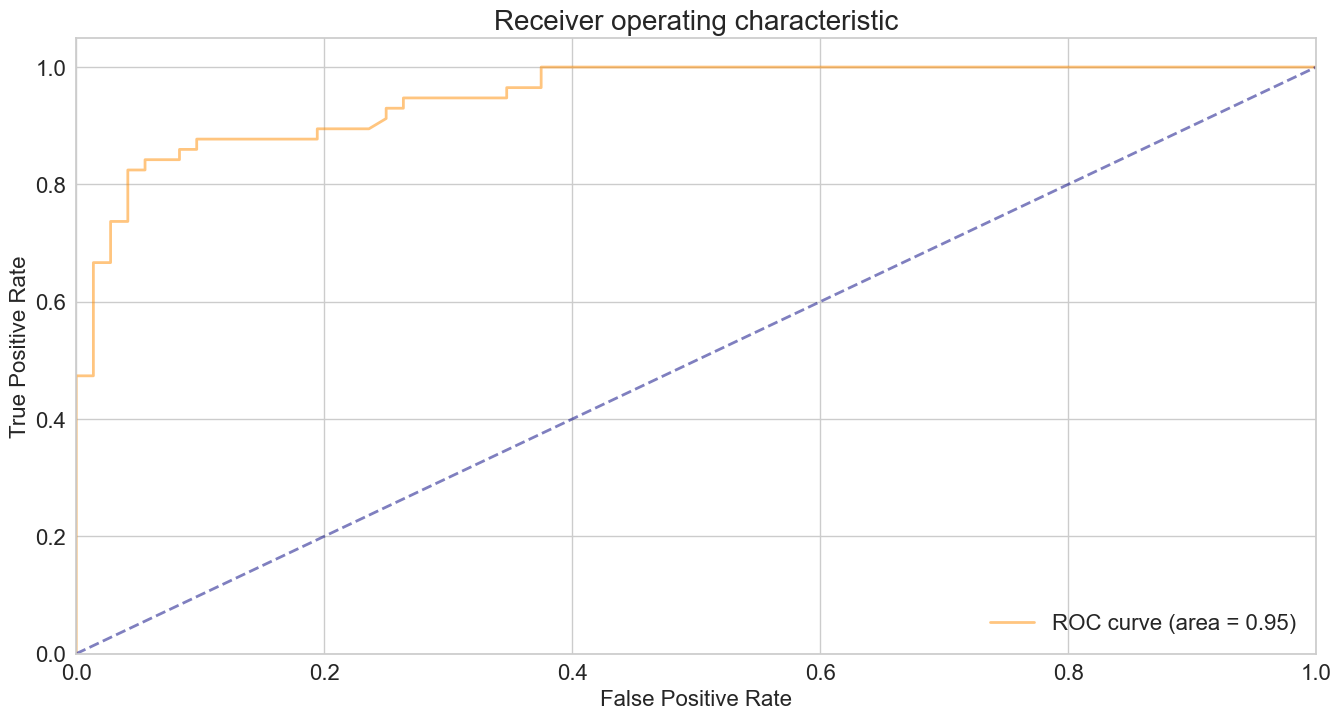

In [268]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Чем больше площадь под ROC-кривой, тем лучше, тем ближе к нашей идеальной точке (1.0).

###### Важность признаков:

In [357]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

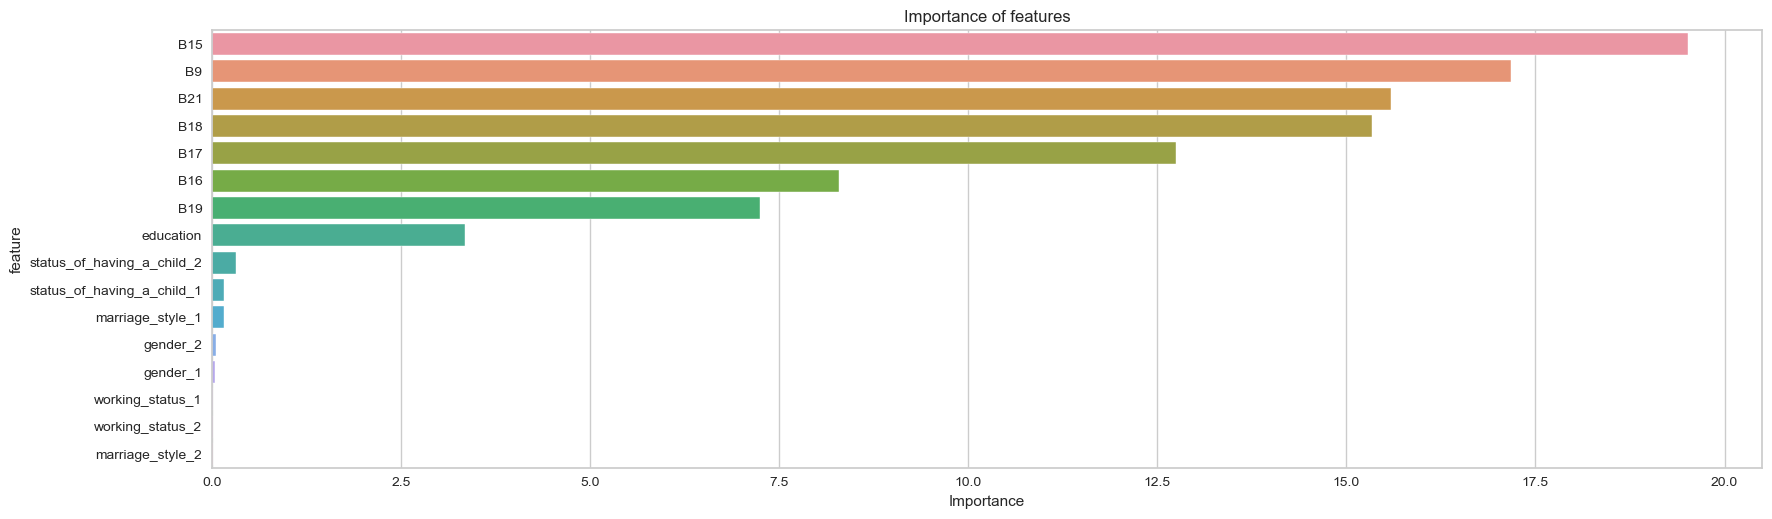

In [358]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

###### Сохранение модели (до того, как ее еще позднее поправим):

In [359]:
best_model = CatBoostClassifier(iterations=300)
best_model = model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    verbose=False
)

best_model.save_model('catboost_model.json')
best_model.save_model('catboost_model.bin')

In [360]:
best_model.load_model('catboost_model.bin')
print(best_model.get_params())
print(best_model.random_seed_)

{'depth': 3, 'random_seed': 21, 'loss_function': 'Logloss', 'learning_rate': 0.02, 'l2_leaf_reg': 25, 'iterations': 700, 'verbose': 0}
21


# ПОДБОР ГИПЕРПАРАМЕТРОВ

Сообразно предшествующим данным, число итераций стоит снизить - ранее при остановке через 20+ мы получили 334, возьмем сейчас 300.

In [361]:
from catboost import CatBoost

fast_model = CatBoostClassifier(
    random_seed=21,
    iterations=300,
    learning_rate=0.02,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1
)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [362]:
tunned_model = CatBoostClassifier(
    random_seed=21,
    iterations=300,
    learning_rate=0.02,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton' 
)

tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_test, y_test),
    plot=True

)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Построим новую модель, число деревьев в отношении предыдущей идеи повысим на всякий случай на 20%.

In [363]:
best_model = CatBoostClassifier(
    random_seed=21,
    iterations=int(tunned_model.tree_count_ * 1.2)
)

best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100
)

Learning rate set to 0.019219
0:	learn: 0.6840161	total: 69.2ms	remaining: 23.6s
100:	learn: 0.3012698	total: 5.23s	remaining: 12.5s
200:	learn: 0.2477062	total: 12.3s	remaining: 8.6s
300:	learn: 0.2191079	total: 18.3s	remaining: 2.49s
341:	learn: 0.2123818	total: 20.9s	remaining: 0us


# ПОЛУЧЕНИЕ И СОХРАНЕНИЕ ПРЕДСКАЗАНИЯ

In [364]:
test_pool = Pool(X_test, cat_features=cat_features)
predictions=best_model.predict_proba(test_pool)
print(f"Predictions: {predictions}")

Predictions: [[0.90364322 0.09635678]
 [0.88030656 0.11969344]
 [0.06805626 0.93194374]
 [0.89652414 0.10347586]
 [0.94952573 0.05047427]
 [0.98013611 0.01986389]
 [0.60814479 0.39185521]
 [0.12772557 0.87227443]
 [0.17237327 0.82762673]
 [0.01329001 0.98670999]
 [0.97798515 0.02201485]
 [0.10649671 0.89350329]
 [0.0215578  0.9784422 ]
 [0.01270305 0.98729695]
 [0.16523564 0.83476436]
 [0.60082945 0.39917055]
 [0.42210532 0.57789468]
 [0.11752084 0.88247916]
 [0.74934589 0.25065411]
 [0.87095118 0.12904882]
 [0.18098956 0.81901044]
 [0.24942166 0.75057834]
 [0.01485928 0.98514072]
 [0.00834705 0.99165295]
 [0.97530844 0.02469156]
 [0.9126432  0.0873568 ]
 [0.93126691 0.06873309]
 [0.9813605  0.0186395 ]
 [0.03484541 0.96515459]
 [0.71570632 0.28429368]
 [0.05546386 0.94453614]
 [0.76121096 0.23878904]
 [0.9813605  0.0186395 ]
 [0.65149331 0.34850669]
 [0.89652414 0.10347586]
 [0.00621447 0.99378553]
 [0.74584807 0.25415193]
 [0.34719002 0.65280998]
 [0.92937226 0.07062774]
 [0.10995119

In [365]:
test_predict = predictions
test_predict = pd.DataFrame(test_predict)
test_predict.to_csv('C://Users//romal//Desktop//test_predict.csv', index=False, encoding='utf-8')

# СОХРАНЕНИЕ КОНЕЧНОЙ МОДЕЛИ

In [367]:
pkl_filename = "pickle_best_model_depression.pkl" 

In [368]:
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_model, file)
 